# Lid driven cavity

In this notebook we use Physics Informed Neural Networks (PINNS) to solve the Navier-Stokes equations in a rectangular domain. The Navier-Stokes problem to solve is

\begin{align*}
(\boldsymbol{u} \cdot \nabla) \boldsymbol{u} - \nu \nabla^2 \boldsymbol{u} + \nabla p &= 0, \quad \boldsymbol{x} \in \Omega = (-1, 1)^2\\
\nabla \cdot \boldsymbol{u} &= 0, \quad \boldsymbol{x} \in \Omega = (-1, 1)^2 \\ 
\end{align*}

where $\nu$ is a constant kinematic viscosity, $p(\boldsymbol{x})$ is pressure, $\boldsymbol{u}(\boldsymbol{x}) = u_x(\boldsymbol{x}) \boldsymbol{i} + u_y(\boldsymbol{x}) \boldsymbol{j}$ is the velocity vector and the position vector $\boldsymbol{x} = x \boldsymbol{i} + y \boldsymbol{j}$, with unit vectors $\boldsymbol{i}$ and $\boldsymbol{j}$. The Dirichlet boundary condition for the velocity vector is zero everywhere, except for the top lid, where $\boldsymbol{u}(x, y=1) = (1-x)^2(1+x)^2 \boldsymbol{i}$. There is no boundary condition on pressure, but since the pressure is only present inside a gradient, it can only be found up to a constant. Hence, we specify that $p(x=0, y=0) = 0$.

We start the implementation by importing necessary modules such as [jax](https://docs.jax.dev/en/latest/index.html), [flax](https://flax.readthedocs.io/), where the latter is a module that provides neural networks for JAX. 


In [1]:
# ruff: noqa: I001, E402
import jax
import jax.numpy as jnp
from flax import nnx
jax.config.update("jax_enable_x64", True)

We will solve the Navier-Stokes equations using a multilevel perceptron neural network, where the solution will be approximated as

$$
F_{\theta}(\boldsymbol{x}; \theta) =  W^{L} \sigma( W^{L-1} \ldots \sigma( W^1 \boldsymbol{x} + \boldsymbol{b}^1) \ldots + \boldsymbol{b}^{L-1})  + \boldsymbol{b}^L
$$

where $\theta = \{W^l, \boldsymbol{b}^l\}_{l=1}^L$ represents all the unknowns in the model and $W^l, \boldsymbol{b}^l$ represents the weights and biases on level $l$. The model contains both velocity components and the pressure, for a total of three scalar outputs: $u_{x}(\boldsymbol{x}), u_y(\boldsymbol{x})$ and $p(\boldsymbol{x})$. Hence $F_{\theta}: \mathbb{R}^2 \rightarrow \mathbb{R}^3$.

We split the coupled $F_{\theta}$ into velocity and pressure

$$
F_{\theta} = \boldsymbol{u}_{\theta} \times p_{\theta}
$$

where $\boldsymbol{u}_{\theta}: \mathbb{R}^2 \rightarrow \mathbb{R}^2$ is a vector function and $p_{\theta}: \mathbb{R}^2 \rightarrow \mathbb{R}$ is a scalar function. 

We start the implementation by creating multilayer perceptron functionspaces for $\boldsymbol{u}_{\theta}$ and $p_{\theta}$, and then combining these to a space for $F_{\theta}$ using a Cartesian product:

In [2]:
from jaxfun.pinns.module import (
    CompositeMLP,
    FlaxFunction,
    MLPSpace,
)

V = MLPSpace([8], dims=2, rank=1, name="V")  # Vector space for velocity
Q = MLPSpace([8], dims=2, rank=0, name="Q")  # Scalar space for pressure
VQ = CompositeMLP((V, Q))  # Coupled space V x Q

F = FlaxFunction(
    VQ,
    "up",
    rngs=nnx.Rngs(2002),
    kernel_init=nnx.initializers.xavier_normal(dtype=float),
)

u, p = F # Split into separate components

Note that `u` and `p` both are `FlaxFunction`s, that are subclasses of the Sympy [Function](https://docs.sympy.org/latest/modules/functions/index.html). However, in Jaxfun these functions have some additional properties, that makes it easy to describe equations.

We can inspect `u` and `p`

In [3]:
from IPython.display import display
display(u)
display(u.doit())
display(p)
display(p.doit())

u(x, y; VQ_0)

(u_x(x, y))*N.i + (u_y(x, y))*N.j

p(x, y; VQ_1)

p(x, y)

Note that `u` and `p` are in unevaluated state, whereas `u.doit()` and `p.doit()` returns sympy functions for the computational space. If we check the type of `u.doit()`, we get that it is a `VectorAdd`, because the vector is an addition of the two vector components in $(u_x(x, y))\boldsymbol{i} + (u_y(x, y)) \boldsymbol{j}$. The three terms $u_x(x, y), u_y(x, y)$ and $p(x, y)$ are all sympy functions and of type `AppliedUndef`.


In [4]:
display(type(u.doit()))
display(help(p.doit()))

sympy.vector.vector.VectorAdd

Help on p object:

class p(sympy.core.function.AppliedUndef)
 |  p(*args)
 |
 |  Method resolution order:
 |      p
 |      sympy.core.function.AppliedUndef
 |      sympy.core.function.Function
 |      sympy.core.function.Application
 |      sympy.core.expr.Expr
 |      sympy.core.basic.Basic
 |      sympy.printing.defaults.Printable
 |      sympy.core.evalf.EvalfMixin
 |      builtins.object
 |
 |  Data and other attributes defined here:
 |
 |  argument = 2
 |
 |  default_assumptions = {}
 |
 |  functionspace_name = 'VQ_1'
 |
 |  global_index = 2
 |
 |  module = MLP(
 |    linear_in=Linear(
 |      kernel=Param(
 |       ...neral=<fun...
 |
 |  name = 'p'
 |
 |  rank_parent = 0
 |
 |  ----------------------------------------------------------------------
 |  Static methods inherited from sympy.core.function.AppliedUndef:
 |
 |  __new__(cls, *args, **options)
 |      Create and return a new object.  See help(type) for accurate signature.
 |
 |  -----------------------------------------

None

We can now describe the Navier-Stokes equations using `Div`, `Grad` and `Dot` from Jaxfun. First specify the Reynolds number, the kinematic viscosity and then the equations

In [5]:
import sympy as sp
from jaxfun import Div, Dot, Grad, Outer, Cross, Curl
from jaxfun.arguments import Constant, Identity

Re = 10.0       # Define Reynolds number
nu = Constant('nu', 2.0 / Re) # Define kinematic viscosity. A number works as well, but the Constant prints better.
R1 = Dot(Grad(u), u) - nu * Div(Grad(u)) + Grad(p)
#I = Identity(VQ.system)
#R1 = Div(Outer(u, u)) - Div(nu*(Grad(u) + Grad(u).T - sp.Rational(2, 3)*Div(u)*I) + p*I) # Alternative form
R2 = Div(u)

Here `R1` represents the residual of the momentum vector equation $\mathcal{R}^1_{\theta}$, whereas `R2` represents the residual of the scalar divergence constraint $\mathcal{R}^2_{\theta}$.

We can inspect the residuals:

In [6]:
R1

-nu*Div(Grad(u(x, y; VQ_0))) + Dot(Grad(u(x, y; VQ_0)), u(x, y; VQ_0)) + Grad(p(x, y; VQ_1))

`R1` represents a vector equation and we can expand it using `doit`:

In [7]:
R1.doit()

(u_x(x, y)*Derivative(u_x(x, y), x) + u_y(x, y)*Derivative(u_x(x, y), y) + Derivative(p(x, y), x) - 0.2*Derivative(u_x(x, y), (x, 2)) - 0.2*Derivative(u_x(x, y), (y, 2)))*N.i + (u_x(x, y)*Derivative(u_y(x, y), x) + u_y(x, y)*Derivative(u_y(x, y), y) + Derivative(p(x, y), y) - 0.2*Derivative(u_y(x, y), (x, 2)) - 0.2*Derivative(u_y(x, y), (y, 2)))*N.j

The divergence constraint is a scalar equation

In [8]:
display(R2)
display(R2.doit())

Div(u(x, y; VQ_0))

Derivative(u_x(x, y), x) + Derivative(u_y(x, y), y)

To solve the equations we will use a least squares method and for this we need to create collocation points both inside and on the domain. There are some simple helper functions in `jaxfun.pinns.mesh` that can help use create such points. Below `xyi` are $N^2$ points inside the domain $\boldsymbol{x}^{\Omega} = \{(x_i, y_i)\}_{i=0}^{N^2-1}$, `xyb` are $4N+4$ points on the domain $\boldsymbol{x}^{\partial \Omega} = \{(x_i, y_i)\}_{i=0}^{4N+3}$, including the four corners, and `xyp` is simply origo.

In [9]:
from jaxfun.pinns.mesh import Rectangle 

N = 20
mesh = Rectangle(N, N, -1, 1, -1, 1)
xyi = mesh.get_points_inside_domain("random")
xyb = mesh.get_points_on_domain("random")
xyp = jnp.array([[0.0, 0.0]])

The boundary conditions on the velocity vector needs to be specified and to this end we can use the function `DirichletBC`:

In [10]:
import sympy as sp
from jaxfun.pinns.bcs import DirichletBC

x, y = VQ.system.base_scalars()
ub = DirichletBC(
    u, xyb, ((sp.Piecewise((0, y < 1), ((1 - x) ** 2 * (1 + x) ** 2, True))), 0)
)

Here `ub` is simply an array of numbers that will act as targets for the velocity vector on the chosen boundary points `xyb`. The target is called $\boldsymbol{u}_b$ below.

The unknowns will now be found using the least squares method, which is to minimize

\begin{equation*}
\underset{\theta \in \mathbb{R}^M}{\text{minimize}}\, L(\theta):=\frac{1}{N^2}\sum_{k=0}^1\sum_{i=0}^{N^2-1} \mathcal{R}^{1}_{\theta} (\boldsymbol{x}^{\Omega}_i)^2 \cdot \boldsymbol{i}_k + \frac{1}{N^2}\sum_{i=0}^{N^2-1} \mathcal{R}^{2}_{\theta}(\boldsymbol{x}^{\Omega}_i)^2+ \frac{1}{4(N+1)} \sum_{k=0}^1 \sum_{i=0}^{4N+3} (\boldsymbol{u}_{\theta}(\boldsymbol{x}^{\partial \Omega}_i) - \boldsymbol{u}_b(\boldsymbol{x}^{\partial \Omega}_i))^2 \cdot \boldsymbol{i}_k + p_{\theta}(0, 0)
\end{equation*}

where $\boldsymbol{i}_0 = \boldsymbol{i}$ and $\boldsymbol{i}_1 = \boldsymbol{j}$.
We define the minimization problem using the jaxfun class `LSQR`, which takes as argument a tuple of tuples containing the residual, the collocation points to use for that residual, the target (defaults to zero) and optionally some weights. The weights may be constants or 1D arrays of length the number of collocation points. If weights are provided, then these are applied to the squared residuals in each term above. For example, the divergence loss becomes

$$
\frac{1}{N^2}\sum_{i=0}^{N^2-1} \omega_i \mathcal{R}^{2}_{\theta}(\boldsymbol{x}^{\Omega}_i)^2
$$

using weights $\{\omega_i\}_{i=0}^{N^2-1}$. Below the pressure anchor is simply weighted with a constant factor 10 and the boundary conditions with a factor 2.

In [11]:
from jaxfun.pinns import LSQR 

loss_fn = LSQR(((R1, xyi), (R2, xyi), (u, xyb, ub, 2), (p, xyp, 0, 10)))

There are six scalar losses computed with `loss_fn`

In [12]:
loss_fn.residuals

Each loss may be computed individually, or we can compute the whole sum $L(\theta)$. Since we have not started the least squares solver yet, the module for now only contains randomly initialized weights and the loss is significant

In [13]:
loss_fn(F.module)

Array(1.84277569, dtype=float64)

To create a solver, we use the [optax](https://optax.readthedocs.io/en/latest/) module, and start with the Adam optimizer

In [14]:
from jaxfun.pinns import run_optimizer, train
import optax 

train_step = train(loss_fn)
opt = optax.adam(1e-3)
opt_adam = nnx.Optimizer(F.module, opt)
#run_optimizer(train_step, F.module, opt_adam, 5000, "Adam", 1000)

In [15]:
from soap_jax import soap

opts = soap(
    learning_rate=1e-3,
    b1=0.95,
    b2=0.95,
    weight_decay=0.01,
    precondition_frequency=5,
)
opt_soap = nnx.Optimizer(F.module, opts)
run_optimizer(train_step, F.module, opt_soap, 5000, "Soap", 1000)

Epoch 1000 Soap, loss: 0.0411251969950661
Epoch 2000 Soap, loss: 0.0124139021554712
Epoch 3000 Soap, loss: 0.0035465907831801545
Epoch 4000 Soap, loss: 0.0021179647751386464
Epoch 5000 Soap, loss: 0.0016132370330610517


The loss has now been reduced, but is still far from zero.

In [16]:
loss_fn(F.module)

Array(0.00161307, dtype=float64)

To refine the solution, we use a low-memory BFGS solver:

In [17]:
optlbfgs = optax.lbfgs(
    memory_size=100,
    linesearch=optax.scale_by_zoom_linesearch(20, max_learning_rate=1.0),
)
opt_lbfgs = nnx.Optimizer(F.module, optlbfgs)
run_optimizer(train_step, F.module, opt_lbfgs, 5000, "LBFGS", 1000)

Epoch 1000 LBFGS, loss: 0.0012078484211224985
Epoch 2000 LBFGS, loss: 0.0010761720105641457
Epoch 3000 LBFGS, loss: 0.0010020961377853767
Epoch 4000 LBFGS, loss: 0.0009433716520697902
Epoch 5000 LBFGS, loss: 0.000894180294515204


In [18]:
loss_fn(F.module)

Array(0.00089411, dtype=float64)

And finally a full Newton method, which is still quite slow because we have not yet implemented a preconditioner.

In [19]:
from jaxfun.pinns.hessoptimizer import hess
opthess = hess(
    use_lstsq=False,
    cg_max_iter=100,
    linesearch=optax.scale_by_zoom_linesearch(25, max_learning_rate=1.0),
)
opt_hess = nnx.Optimizer(F.module, opthess)
run_optimizer(train_step, F.module, opt_hess, 100, "Hess", 10)

Epoch 10 Hess, loss: 0.0008538636809173302
Epoch 20 Hess, loss: 0.0008386635628110302
Epoch 30 Hess, loss: 0.0008283122012936292
Epoch 40 Hess, loss: 0.0008174946801205643
Epoch 50 Hess, loss: 0.0008098897360803848
Epoch 60 Hess, loss: 0.0008008683789392249
Epoch 70 Hess, loss: 0.0007947113685351388
Epoch 80 Hess, loss: 0.0007891143080868378
Epoch 90 Hess, loss: 0.0007849938755968758
Epoch 100 Hess, loss: 0.0007809926090843049


We can now visualize the solution using [matplotlib](https://matplotlib.org/)

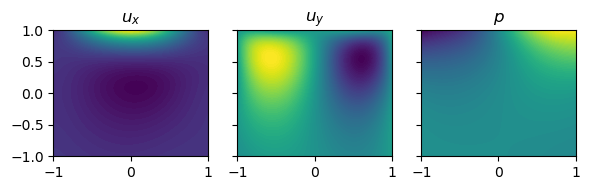

In [20]:
import matplotlib.pyplot as plt
yj = jnp.linspace(-1, 1, 50)
xx, yy = jnp.meshgrid(yj, yj, sparse=False, indexing="ij")
z = jnp.column_stack((xx.ravel(), yy.ravel()))
uvp = F.module(z)
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(6, 2))
axs[0].contourf(xx, yy, uvp[:, 0].reshape(xx.shape), 100)
axs[0].set_title(r'$u_x$')
axs[1].contourf(xx, yy, uvp[:, 1].reshape(xx.shape), 100)
axs[1].set_title(r'$u_y$')
axs[2].contourf(xx, yy, uvp[:, 2].reshape(xx.shape), 100)
axs[2].set_title(r'$p$')
fig.set_tight_layout('tight')

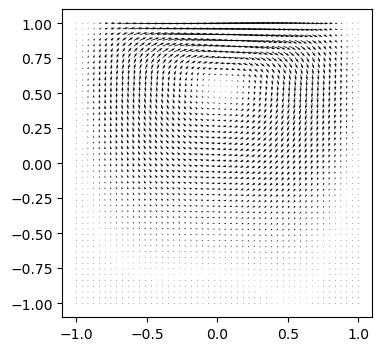

In [21]:
plt.figure(figsize=(4, 4))
plt.quiver(xx, yy, uvp[:, 0].reshape(xx.shape), uvp[:, 1].reshape(xx.shape));

We can also compute the losses of each equation. Here we get the loss of each collocation point in $\boldsymbol{x}^{\Omega}$ for the momentum equation in the x-direction:

In [22]:
loss_fn.compute_residual_i(F.module, 0)

Array([ 6.31199499e-03, -6.46959982e-04,  2.02251825e-02,  1.36782383e-02,
       -6.03549052e-03, -1.41415499e-03,  1.55308585e-03,  4.69047998e-03,
        1.32412268e-02,  6.11800235e-03, -8.35552422e-03, -9.08307363e-03,
       -1.12453498e-03, -1.35486047e-02,  1.51221433e-02,  5.53367916e-03,
        1.52141628e-02, -1.88493656e-04,  5.29683322e-03,  4.87357953e-03,
       -4.72418411e-03, -3.48286816e-03,  3.20460521e-04, -1.22498117e-02,
        8.09649494e-04,  2.14155330e-03,  6.28639369e-03,  7.84608342e-03,
        4.67813778e-03, -2.90751603e-03,  1.23495412e-03, -1.31435535e-02,
        1.29889674e-02,  8.44152999e-03, -1.07622701e-02, -1.34024871e-02,
        2.44970820e-03, -5.29195388e-03,  3.08812403e-03,  5.72434700e-03,
       -3.23450579e-02,  1.04028059e-02, -8.58092428e-03,  5.53517622e-03,
        8.18296829e-03,  7.06275684e-03,  7.57516780e-03, -1.19765051e-02,
       -4.15913518e-03, -3.70719239e-03,  4.93530599e-03,  4.46896916e-03,
       -4.13138257e-03, -

The loss can be plotted using for example scatter. Below is the scatter plot of the error in the divergence constraint.

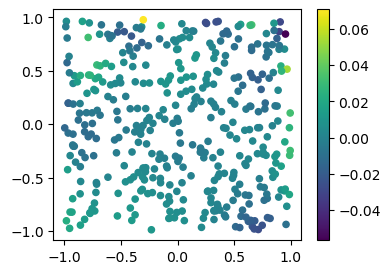

In [23]:
plt.figure(figsize=(4, 3))
plt.scatter(*xyi.T, c=loss_fn.compute_residual_i(F.module, 2), s=20)
plt.colorbar();

And finally a vector plot of the velocity vectors:

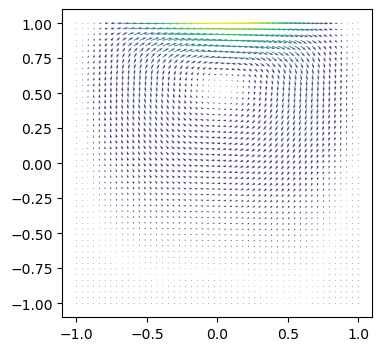

In [24]:
plt.figure(figsize=(4, 4))
plt.quiver(xx, yy, uvp[:, 0], uvp[:, 1], jnp.linalg.norm(uvp[:, :2], axis=1));

In [25]:
loss_fn.compute_residuals(F.module)

Array([9.59450079e-05, 7.83289126e-05, 1.35069657e-04, 2.11069476e-04,
       2.60164213e-04, 4.66470674e-09], dtype=float64)